# Supriti Rosita - 200968260 - ML Project Phase 2

# Movie Recommendation System
Recommender systems are one of the most successful and widespread application of machine learning technologies in business.
One can find large scale recommender systems in retail, video on demand, or music streaming.

## Contents
- Content based filtering
- Collaborative Filtering
    - Memory based collaborative filtering
        - User-Item Filtering
        - Item-Item Filtering
    - Model based collaborative filtering
        - Single Value Decomposition(SVD)
- Evaluating Collaborative Filtering using SVD
- Hybrid Model

## Importing Libraries

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## Dataset: Movielens(ml-latest-small: ratings,movies)

In [2]:
# Reading ratings file
ratings = pd.read_csv("ratings.csv")

# Reading movies file
movies = pd.read_csv("movies.csv")

In [3]:
df_movies = movies 
df_ratings = ratings 

# Content based filtering
The concepts of Term Frequency (TF) and Inverse Document Frequency (IDF) are used in content based filtering mechanisms and also in information retrieval systems(such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

### Term Frequency (TF) and Inverse Document Frequency (IDF)
TF: the frequency of a word in a document. 
IDF: the inverse of the document frequency among the whole corpus of documents. 
TF-IDF is used mainly because of two reasons: Suppose we search for “the rise of analytics” on Google. It is certain that “the” will occur more frequently than “analytics” but the relative importance of analytics is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Considering "genres" as an important parameter to recommend user the movie he watches based on the genres of movie a user has already watched.

![](https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336)

For calculating distances, widely used similarity coefficients such as Euclidean, Cosine, Pearson Correlation etc., are calculated.

In this case cosine distance is used. Here the point of interest in similarity-higher the value more similar they are. (Since the below function gives us the distance, it will be deducted from 1.) 

**Cosine similarity**
is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.
Given two vectors of attributes, A and B, the cosine similarity, cos(θ), is represented using a dot product and magnitude as
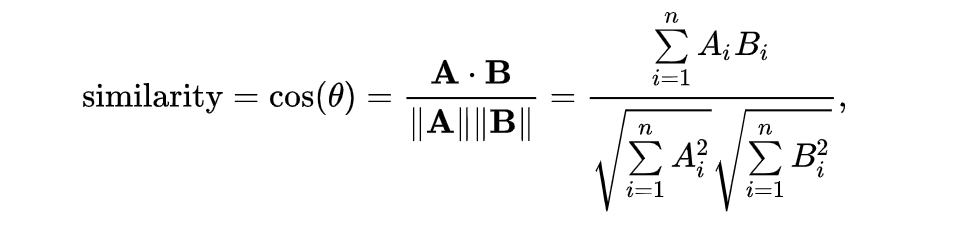


In [4]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])

cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
#print(cosine_sim_movies)

In [5]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 10 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:10]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 10 most similar movies
    return df_movies['title'].iloc[movie_indices]


In [6]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                         Four Rooms (1995)
18     Ace Ventura: When Nature Calls (1995)
58                           Bio-Dome (1996)
61                             Friday (1995)
79                        Black Sheep (1996)
90                          Mr. Wrong (1996)
92                      Happy Gilmore (1996)
104           Steal Big, Steal Little (1995)
108            Flirting With Disaster (1996)
Name: title, dtype: object

In [7]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)

In [8]:
#rc=input("enter user id:")
#rcm=int(rc)
#get_recommendation_content_model(rcm)

## Model evaluation with KNN
Here the model is evaluated on based of if there is exact match of genres with the genres of movie which is already watch by user.

In [9]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = df_movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [10]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in df_movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
                #print(colums["genres"])
                #print(predicted_genre)
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.8840986336367161
Fault:0.11590136636328384


In [11]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [12]:
df_movies = movies 
df_ratings = ratings 

## Collaborative Filtering
Types of collaborative filtering techniques
* Memory based 
 - User-Item Filtering
 - Item-Item Filtering
* Model based 
 - Matrix Factorization
 ![alt text](https://cdn-images-1.medium.com/max/1500/1*7uW5hLXztSu_FOmZOWpB6g.png)

### Memory Based Approach
 ![alt text](https://cdn-images-1.medium.com/max/1500/1*QvhetbRjCr1vryTch_2HZQ.jpeg)

In either scenario, we builds a similarity matrix. 

For user-user collaborative filtering, the user-similarity matrix will consist of some distance metrics that measure the similarity between any two pairs of users.

Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:

- **Jaccard Similarity**
- **Cosine Similarity** 
- **Pearson Similarity** 

#### Item-Item Filtering
Item-item collaborative filtering, or item-based, or item-to-item, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings of those items.


Item-item collaborative filtering was invented and used by Amazon.com
![alt text](https://cdn-images-1.medium.com/max/1600/1*skK2fqWiBF7weHU8SjuCzw.png)

ITEM-ITEM collaborative filtering look for items that are similar to the articles that user has already rated and recommend most similar articles. But what does that mean when we say item-item similarity? In this case we don’t mean whether two items are the same by attribute like Fountain pen and pilot pen are similar because both are pen. Instead, what similarity means is how people treat two items the same in terms of like and dislike.

It is quite similar to content-based filtering, but instead of finding user’s look-alike, a movie’s look-alike is found. Once the movie’s look-alike matrix is developed, one can easily recommend alike movies to user who have rated any movie from the dataset. 
(This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.)

#### Implementation (Item-Item Filtering)

In [13]:
df_movies_ratings=pd.merge(df_movies, df_ratings)

In [14]:
df_movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [15]:
df_movies_ratings.shape

(100836, 6)

Pivot table function is used for one to one maping between movies, user and their rating. 
(The default pivot_table command takes average if we have multiple values of one combination.)

In [16]:
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(9724, 610)

In [17]:
ratings_matrix_items.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
ratings_matrix_items.shape

(9724, 610)

In [19]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.values, metric="cosine" )
#Filling diagonals with 0s for future use when sorting is done
np.fill_diagonal( movie_similarity, 0) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


The function below stake the movie name as a input and finds the movies which are similar to this movie.
This function first find the index of movie in movies frame and then take the similarity of movie and align in movies dataframe; therefore it helps determine the similarity of the movie with all other movies.

In [20]:
def item_similarity(movieName): 
    """
    recomendates similar movies
   :param data: name of the movie 
   """
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]

        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

Here, user id of the user for whom movies should be recommended is provided:
First, the movies which are rated 5 or 4.5 by the user for whom we want to recommend movies is found. (since, in Item-Item similarity, movies are recommended to the user based on their previous selection.)

Thus, to foster our algorithm movies that are most-liked/highly rated by the user are found and on its basis similar movies are recommended.

The function has appended the similarity of the movie highly rated by the user to the movies data frame.
The frame is sorted in descending order to list out the movies which are highly similar to movie highly rated by the user.
Upon filtering the movies that are most similar, if similarity is greater than 0.45 then the movie is considered.
One final filtering process is done to reccomend to the user, the movies he has not seen.

In [21]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= df_ratings[df_ratings['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [22]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movie_id']==id]['title'])
    return movie_titles

In [23]:
user_id=50
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [659    Godfather, The (1972)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 1644    Willow (1988)
Name: title, dtype: object]


#### User-Item Filtering
The underlying assumption of this collaborative filtering approach is that if a person A has the same opinion as a person B on a movie, A is more likely to have B's opinion on a different movies than that of a randomly chosen person.
![alt text](https://cdn-images-1.medium.com/max/1500/0*o0zVW2O6Rv-LI5Mu.png)

Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. 
(Drawback: This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.)

#### Implementation (User-Item Filtering)

A similar matrix to that of Item-Item Similarity will be created but here, rows will be userId and columns will be movieId-since we want to detemine a vector of different users.
In similar ways distance and similarity between users is found.

In [24]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.values, metric="cosine" )
#Filling diagonals with 0s for future use when sorting is done
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users


,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


In the above matrix, similarity of users in columns with respective users in row. So the user with highest similarity can be found by finding maximum value in a column. Thus, a pair of similar users can be determined.

In [25]:
ratings_matrix_users.idxmax(axis=1)

0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

In [26]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 10 )

547     76
241    467
277    337
348    454
218    238
407    278
352     45
97     600
381     20
607    479
dtype: int64

In [27]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()

In [28]:
df_similar_user.columns=['similarUser']

In [29]:
df_similar_user

,similarUser
0,265
1,365
2,312
3,390
4,469
...,...
605,473
606,569
607,479
608,339


The function below takes the Id of the user to whom movie reccomendations should be made. It is done by finding similar users and filtering movies which are highly rated by those users and recommending them to the given user.

In [30]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user2Movies= df_ratings[df_ratings['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in df_ratings[df_ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

In [31]:
user_id=50
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[1431    Rocky (1976)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 1939    Matrix, The (1999)
Name: title, dtype: object]


### Model Evaluation

In [32]:
def get_user_similar_movies( user1, user2 ):
    
    """""
     Returning common movies and ratings of same for both the users
    :param user1,user2: user ids of 2 users need to compare
    :return: movieIds to user 
    """
    common_movies = df_movies_ratings[df_movies_ratings.userId == user1].merge(
      df_movies_ratings[df_movies_ratings.userId == user2],
      on = "movieId",
      how = "inner" )
    common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
    return common_movies

In [33]:
get_user_similar_movies(587,511)

,title_x,userId_x,rating_x,userId_y,rating_y
0,Forrest Gump (1994),587,4.0,511,4.5
1,Life Is Beautiful (La Vita è bella) (1997),587,5.0,511,4.5
2,"Matrix, The (1999)",587,4.0,511,5.0


### Challenges with User similarity (above two methods):
- The challenge with calculating user similarity is the user needs to have some prior purchases and should have rated them.
- This recommendation technique does not work for new users.
- The system need to wait until the user make some purchases and rates them. Only then similar users can be found and recommendations can be made. This is called Cold Start Problem.

### Single Value Decomposition

Singular value decomposition is a method of decomposing a matrix into three other matrices:
<img src="https://cdn-images-1.medium.com/max/1600/0*i4rDKIAE0o1ZXtBd.">

Where:

    A is an m × n matrix
    U is an m × r orthogonal matrix
    S is an r × r diagonal matrix
    V is an r × n orthogonal matrix

#### Data reduction
A typical machine learning problem might have several hundred or more variables, while many machine learning algorithms will break down if presented with more than a few dozen. This makes singular value decomposition indispensable in ML for variable reduction.

An SVD with a reduced number of singular values can closely approximate a matrix. This can be used for data compression by storing the truncated forms of U, S, and V in place of A and for variable reduction by replacing A with U.

### Matrix Factorization
Memory-based collaborative filtering approaches that compute distance relationships between items or users have these two major issues:

* It doesn’t scale particularly well to massive datasets, especially for real-time recommendations based on user behavior similarities — which takes a lot of computations.
* Ratings matrices may be overfitting to noisy representations of user tastes and preferences. When we use distance based “neighborhood” approaches on raw data, we match to sparse low-level details that we assume represent the user’s preference vector instead of the vector itself.
<img src="https://cdn-images-1.medium.com/max/1600/1*bWAAyciKq580ArTix_O3nw.jpeg">

Thus application of the Dimensionality Reduction technique helps derive the tastes and preferences from raw data, otherwise known as doing <b>low-rank matrix factorization</b>.

   * It helps discover hidden correlations / features in the raw data.
   * It removes redundant and noisy features that are not useful.
   * It interprets and visualizes the data easily.
   * It also provides access for easier data storage and processing.

### Implementation

In [34]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv("ratings.csv")

# Reading movies file
movies = pd.read_csv("movies.csv")

In [35]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


To format of our ratings matrix to be one row per user and one column per movie we pivot ratings and call the new variable Ratings (with a capital *R).

In [36]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#de-normalizing the data (normalize by each users mean) and converting it from a dataframe to a numpy array.
R = Ratings.values
print(R)
user_ratings_mean = np.mean(R, axis = 1)
print(user_ratings_mean.size)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) 
## Making the user_ratings_mean vertical by reshaping


[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]
610


### Model-Based Collaborative Filtering

<b>Model-based Collaborative Filtering</b> is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

   * The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
   * When we encounter a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
   * Fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

Checking Sparsity of the ratings dataset:

In [38]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens(ml-latest-small) dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens(ml-latest-small) dataset is 98.3%


A well-known matrix factorization method is Singular value decomposition (SVD). At a high level, SVD is an algorithm that decomposes a matrix $A$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $A$. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:
<img src="https://cdn-images-1.medium.com/max/1600/1*W4MnB2hyvgqedLmwJLrpqw.png">

where $A$ is the input data matrix (users's ratings), $U$ is the left singular vectors (user "features" matrix), $\Sigma$ is the diagonal matrix of singular values (essentially weights/strengths of each concept), and  $V^{T}$ is the right singluar vectors (movie "features" matrix). $U$ and $V^{T}$ are column orthonomal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, in this case, I have taken these matrices and keep only the top $k$ features, which can be thought of as the underlying tastes and preferences vectors.

### SVD (Setup)
Scipy and Numpy both have functions to do the singular value decomposition. In this case the Scipy function svds is used because it let’s us choose how many latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [39]:
from scipy.sparse.linalg import svds 

In [40]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [41]:
print('Size of sigma: ' , sigma.size)

Size of sigma:  50


Since we are leveraging matrix multiplication to get predictions, we willl convert the $\Sigma$ (now are values) to the diagonal matrix form.

In [42]:
sigma = np.diag(sigma)

In [43]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 67.86628347   0.           0.         ...   0.           0.
    0.        ]
 [  0.          68.1967072    0.         ...   0.           0.
    0.        ]
 [  0.           0.          69.02678246 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 184.86187801   0.
    0.        ]
 [  0.           0.           0.         ...   0.         231.22453421
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  474.20606204]]


In [44]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (610, 50)
Shape of Vt:  (50, 9724)


### Making Predictions from the Decomposed Matrices

We now have everything we need to make movie ratings predictions for every user. This is done by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $A$.

But first, the user means needs to be added back to get the actual star ratings prediction.

In [45]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [46]:
print('All user predicted rating : ', all_user_predicted_ratings.shape)

All user predicted rating :  (610, 9724)


With the predictions matrix for every user, we can build a function to recommend movies for any user. We return the list of movies the user has already rated, for the sake of comparison.

We will use the column names from the ratings df

In [47]:
print('Rating Dataframe column names', Ratings.columns)

Rating Dataframe column names Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)


In [48]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


A function to return the movies with the highest predicted rating that the specified user hasn't already rated needs to be developed. Though any explicit movie content features (such as genre or title) wasn't used, we merge in that information to get a more complete picture of the recommendations.

In [49]:
def recommend_movies(userID, num_recommendations=20):
    """
    Implementation of SVD by hand
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    predictions=preds
    original_ratings=ratings
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Recommedning 20 movies for user with ID 150

In [71]:
already_rated, predictions = recommend_movies(130)

User 130 has already rated 28 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [51]:
# Top 20 movies that User 130 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres
25,150,1356,5.0,854203229,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
5,150,32,5.0,854203071,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
12,150,141,5.0,854203072,"Birdcage, The (1996)",Comedy
17,150,648,4.0,854203072,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
2,150,6,4.0,854203123,Heat (1995),Action|Crime|Thriller
4,150,25,4.0,854203072,Leaving Las Vegas (1995),Drama|Romance
6,150,36,4.0,854203123,Dead Man Walking (1995),Crime|Drama
7,150,52,4.0,854203163,Mighty Aphrodite (1995),Comedy|Drama|Romance
23,150,805,4.0,854203230,"Time to Kill, A (1996)",Drama|Thriller
20,150,780,4.0,854203071,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller


In [52]:
# Top 20 movies that User 130 hopefully will enjoy
predictions

,movieId,title,genres
574,736,Twister (1996),Action|Adventure|Romance|Thriller
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
211,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
607,802,Phenomenon (1996),Drama|Romance
12,17,Sense and Sensibility (1995),Drama|Romance
87,112,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime
558,708,"Truth About Cats & Dogs, The (1996)",Comedy|Romance
599,788,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi
886,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
634,852,Tin Cup (1996),Comedy|Drama|Romance


These look like pretty good recommendations. Although the genre of the movie wasn't used as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. The model has recommended some Action, Adventure, Romance, Thriller movies - all of which were genres of some of this user's top rated movies.

### Model Evaluation
Instead of manually analyzing, we deploy the Surprise library that provids various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the ml-latest-small dataset. It is a Python scikit building and analyzing recommender systems.

In [53]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, KFold

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


# Split the dataset for 5-fold evaluation
cv = KFold(n_splits=5, random_state=42, shuffle=False)

In [54]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8702  0.8725  0.8749  0.8830  0.8664  0.8734  0.0055  
Fit time          5.29    5.47    5.84    6.02    6.51    5.82    0.43    
Test time         0.16    0.23    0.24    0.13    0.23    0.20    0.04    


{'test_rmse': array([0.8701948 , 0.87252617, 0.87492067, 0.88296786, 0.86642835]),
 'fit_time': (5.285962343215942,
  5.465044736862183,
  5.843364238739014,
  6.016512870788574,
  6.506091594696045),
 'test_time': (0.1605367660522461,
  0.22639679908752441,
  0.24434447288513184,
  0.13164186477661133,
  0.22637510299682617)}

In [55]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8651  0.8715  0.8798  0.8792  0.8692  0.8729  0.0057  
MAE (testset)     0.6656  0.6683  0.6746  0.6761  0.6713  0.6712  0.0039  
Fit time          6.06    5.47    5.67    5.17    5.40    5.56    0.30    
Test time         0.15    0.15    0.29    0.14    0.20    0.19    0.05    


{'test_rmse': array([0.86506077, 0.87146662, 0.87975912, 0.87920958, 0.86918137]),
 'test_mae': array([0.66559499, 0.66825537, 0.67456345, 0.67614527, 0.6712679 ]),
 'fit_time': (6.063531398773193,
  5.474724054336548,
  5.6739702224731445,
  5.174916744232178,
  5.396745443344116),
 'test_time': (0.14760565757751465,
  0.1545886993408203,
  0.28919434547424316,
  0.14466476440429688,
  0.20246505737304688)}

We get a mean Root Mean Square Error[RMSE]= 0.87 which is pretty good. Let's now train on the dataset and arrive at predictions.

In [56]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [57]:
#checking for ratings given by user with ID 150
ratings[ratings['userId'] == 150]

,userId,movieId,rating,timestamp
22277,150,3,3.0,854203124
22278,150,5,3.0,854203124
22279,150,6,4.0,854203123
22280,150,7,3.0,854203124
22281,150,25,4.0,854203072
22282,150,32,5.0,854203071
22283,150,36,4.0,854203123
22284,150,52,4.0,854203163
22285,150,58,3.0,854203163
22286,150,62,3.0,854203072


Using SVD to predict the rating that User with ID 150 will give to a random movie (let's say with Movie ID 1994).

In [58]:
svd.predict(150, 1994)

Prediction(uid=150, iid=1994, r_ui=None, est=3.276580936581009, details={'was_impossible': False})

For movie with ID 1994, I get an estimated prediction of 3.18210. The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

In [59]:
svd.predict(150, 100)

Prediction(uid=150, iid=100, r_ui=None, est=3.1545550626261156, details={'was_impossible': False})

In [60]:
svd.predict(150, 194)

Prediction(uid=150, iid=194, r_ui=None, est=3.7209918033494387, details={'was_impossible': False})

In [61]:
svd.predict(150, 190)

Prediction(uid=150, iid=190, r_ui=None, est=3.3444395374826046, details={'was_impossible': False})

The Surprise package has been specially developed to make recommendation based on collaborative filtering easy. It has default implementation for a variety of CF algorithms.

### # Evaluating Collaborative Filtering

***Hit Ratio***
It is ratio of number of hits/ Total recommendation

In [62]:
user_id=50

In [63]:
def evaluation_collaborative_svd_model(userId,userOrItem):
    """
    hydrid the functionality of Collaborative based and svd based model to see if ratings of predicted movies 
    :param userId: userId of user, userOrItem is a boolean value if True it is User-User and if false Item-Item
    :return: dataframe of movies and ratings
    """ 
    movieIdsList= list()
    movieRatingList=list()
    movieIdRating= pd.DataFrame(columns=['movieId','rating'])
    if userOrItem== True:
        movieIdsList=getRecommendedMoviesAsperUserSimilarity(userId)
    else:
        movieIdsList=recommendedMoviesAsperItemSimilarity(user_id)
    for movieId in movieIdsList:
        predict = svd.predict(userId, movieId)
        movieRatingList.append([movieId,predict.est])
        movieIdRating = pd.DataFrame(np.array(movieRatingList), columns=['movieId','rating'])
        count=movieIdRating[(movieIdRating['rating'])>=3]['movieId'].count()
        total=movieIdRating.shape[0]
        hit_ratio= count/total
    return hit_ratio

In [64]:
print("Hit ratio of User-user collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,True))
print("Hit ratio of Item-Item collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,False))

Hit ratio of User-user collaborative filtering
0.6666666666666666
Hit ratio of Item-Item collaborative filtering
0.8888888888888888


### Hybrid model:

After developing individual models as discussed earlier, we now stack them in order to get better results.

Content Based Filtering + SVD

Steps:
1. Run Content based filtering and determine the movies which we want to recommend to the user.
2. Filter and sort the recommendations of CF using SVD predicted ratings.


In [65]:
df_movies=movies
def hybrid_content_svd_model(userId):
    """
    hydrid the functionality of content based and svd based model to recommend user top 10 movies. 
    :param userId: userId of user
    :return: list of movies recommended with rating given by svd model
    """
    pd.options.mode.chained_assignment = None
    recommended_movies_by_content_model = get_recommendation_content_model(userId)
    recommended_movies_by_content_model = df_movies[df_movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    for key, columns in recommended_movies_by_content_model.iterrows():
        predict = svd.predict(userId, columns["movieId"])
        recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est

    return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:7]
        


In [68]:
hm=input("enter user id:")
hcsm=int(hm)
hybrid_content_svd_model(hcsm)

enter user id:344


,movieId,title,genres,svd_rating
5166,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,4.374362
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.373551
2222,2951,"Fistful of Dollars, A (Per un pugno di dollari...",Action|Western,4.318868
933,1233,"Boot, Das (Boat, The) (1981)",Action|Drama|War,4.307810
5260,8636,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX,4.306586
6331,48780,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller,4.286721
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,4.282059


### Conclusion

In this notebook, widely used Movie Recommendation models have been implemented and evaluated. 
From these the hybrid model (Content based + SVD) was developed and each model was evaluated with an appropriate evaluation metric.

Novel technique to evaluate collaborative filtering algorithm by using SVD and hit ratio as a metric is also implemented.

We attempted to build a model-based Collaborative Filtering movie recommendation sytem based on latent features from a low rank matrix factorization method called SVD. As it captures the underlying features driving the raw data, it can scale significantly better to massive datasets as well as make better recommendations based on user's tastes. For SVD model we get an RMSE of <b>0.87</b>.